<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

# Machine Learning Avanzado
*17 de Diciembre de 2024*

#### Integrantes: 
`Jocelyn Cáceres, Kurt Castro, Giuseppe Lavarello, Carlos Saquel`

1) LSTM producción de leche
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo? tendencia, estacionalidad, etc
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados

2) LSTM producción IPSA
    - Obtencion de datos (probablemente directo de la pagina de la bolsa de santiago)
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo?
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados
3) Autoencoder, limpieza de imágenes y extracción de texto
    - Preparación de Datos
    - Visualización de muestra de datos
    - Preprosesamiento de imagenes
    - Autoencoder
        - Separar imagenes (train, test, val)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Limpiar imagenes y visualizar comparacion de 2 o 3 ejemplos
        - Extraer texto y validar 
        - Usar imagen propia "mostrar imagen inicial y después de correr el modelo"

4) Conclusiones y dar formato de Informe
    - Ejemplo: 
        1. Objetivo
        2. Introducción
        3. Metodología 
            - Aca el codigo y las validaciones
        4. Conclusiones    


2) LSTM producción IPSA
    - Obtencion de datos (probablemente directo de la pagina de la bolsa de santiago)
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo?
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados

In [126]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [127]:
df_IPSA = pd.read_excel(r'./Cuadro_13122024183130.xlsx', header=2)

In [128]:
df_IPSA.head()

,Periodo,1.IPSA (índice enero 2003=1000)
0,2003-01-01,1001.99
1,2003-02-01,1014.94
2,2003-03-01,1009.13
3,2003-04-01,1163.96
4,2003-05-01,1231.01


In [129]:
df_IPSA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Periodo                                                 263 non-null    datetime64[ns]
 1   1.IPSA  (índice enero 2003=1000)                        263 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


<Axes: xlabel='Periodo'>

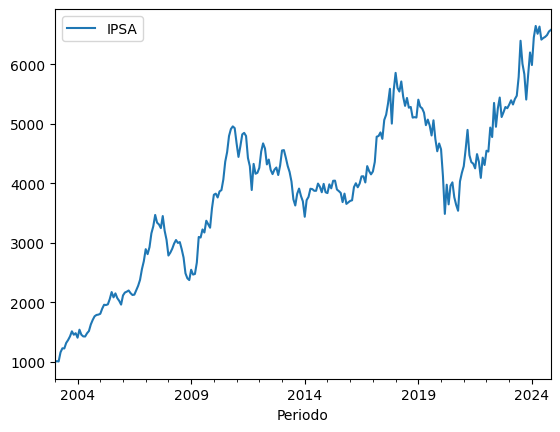

In [130]:
# Seteo de fecha como indice
df_IPSA.set_index('Periodo', inplace=True)

# renombre de columna
df_IPSA.rename(columns={'1.IPSA  (índice enero 2003=1000)                      ':'IPSA'}, inplace=True)

# Escalamiento para modelo
scaler = MinMaxScaler(feature_range=(0, 1))
df_IPSA['Escalado'] = scaler.fit_transform(df_IPSA[['IPSA']])
df_IPSA.plot(y='IPSA')


In [131]:
retrasos = 3 #Numero de columnas de retrazo a crear

for i in range(1, retrasos + 1):
    df_IPSA[f'lag_{i}'] = df_IPSA['Escalado'].shift(i)
    
df_IPSA['Objetivo'] = df_IPSA['Escalado']
df_IPSA.dropna(inplace=True)  # Drop Nans


In [132]:
X = df_IPSA[['lag_1', 'lag_2', 'lag_3']].values
y = df_IPSA['Objetivo'].values

In [133]:
X = X.reshape((X.shape[0], X.shape[1], 1))


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [135]:


# Create the LSTM model
model = Sequential()
model.add(Input((X_train.shape[1], 1)))
model.add(LSTM(units=500, activation='relu', return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,501 (3.83 MB)

 Trainable params: 1,004,501 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:

history = model.fit(X_train, y_train, epochs=500, batch_size=256, verbose=0)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


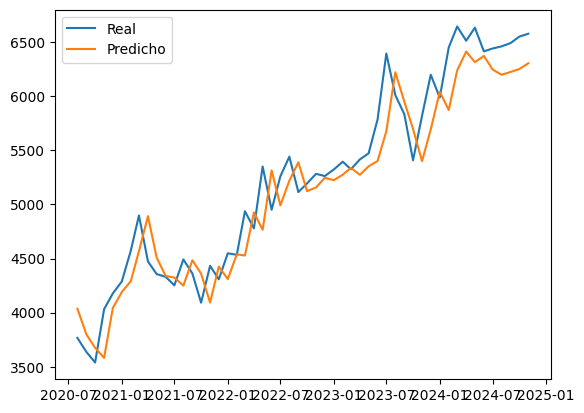

In [137]:

predicciones = model.predict(X_test)


predicciones_reescalado = scaler.inverse_transform(predicciones)
y_test_rescalado = scaler.inverse_transform(y_test.reshape(-1, 1))

dates = list(df_IPSA[int(len(df_IPSA)*0.8):].index)

plt.plot(dates,y_test_rescalado, label='Real')
plt.plot(dates,predicciones_reescalado, label='Predicho')
plt.legend()
plt.show()


In [166]:
mae_IPSA = mean_absolute_error(y_test_rescalado,predicciones_reescalado)
mse_IPSA = mean_squared_error(y_test_rescalado,predicciones_reescalado)
r2_IPSA = r2_score(y_test_rescalado,predicciones_reescalado)

n = len(y_test)
p = X_train.shape[1] # numero de features

adjusted_r2_IPSA = 1 - ((1 - r2_IPSA) * (n - 1)) / (n - p - 1)

print(f"Mean Absolute Error (MAE): {mae_IPSA:.1f}")
print(f"Mean Squared Error (MSE): {mse_IPSA:.1f}")
print(f"Root Mean Squared Error (RMSE): {mse_IPSA**0.5:.1f}")
print(f"R² ajustado: {adjusted_r2_IPSA:.3f}")

Mean Absolute Error (MAE): 235.7
Mean Squared Error (MSE): 80809.8
Root Mean Squared Error (RMSE): 284.3
R² ajustado: 0.892


In [ ]:
#Obtener el valor del ultimo dato y darle formato
last_data = df_IPSA[['lag_1', 'lag_2', 'lag_3']].iloc[-1:].values.reshape(1, 3, 1) 
last_data

array([[[0.98343782],
        [0.97284717],
        [0.96742157]]])

In [165]:
#prediccion de los siguientes n meses
n_meses = 3
for i in range(n_meses):
    predicciones2 = model.predict(last_data)
    last_data = np.roll(last_data, -1)
    last_data[0][-1]=predicciones2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


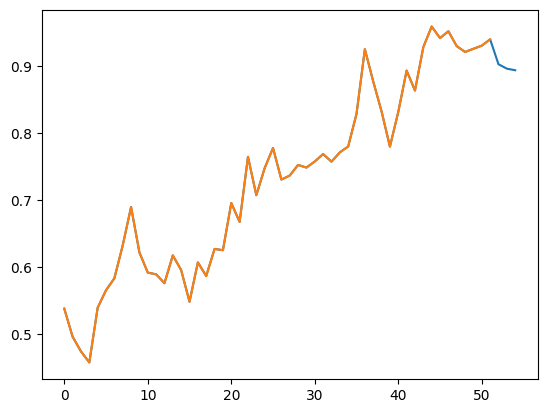

In [168]:
plt.plot(np.concat((predicciones,last_data[0])), label='Predicho')
plt.plot((predicciones), label='Predicho')

